# Study on the Correlation between Planetary Positions and Solar Activity: A Statistical Falsification Framework Based on Red Noise Background

## 1. Project Overview

This project aims to rigorously test whether there is a statistically significant correlation between solar activity (e.g., Sunspot Number, SSN) and planetary heliocentric longitude. Given that solar activity data exhibits strong **non-stationarity** and **autocorrelation (red noise characteristics)**, traditional statistical tests (e.g., Pearson correlation, simple shuffle tests) are highly prone to producing false positive results.

This algorithm constructs a rigorous Null Hypothesis using methods such as **Cyclic Permutation** and **Effective Sample Size correction** to distinguish real physical signals from random red noise fluctuations.

## 2. Detailed Algorithm Workflow

### Step 1: Data Preprocessing and Alignment

* **Input**:
    * Solar activity time series (Daily Sunspot Number).
    * Planetary ephemeris data (Heliocentric longitude, range ).

* **Alignment**: Perform an inner join between  and  using the date index and remove missing values.
* **Effective Sample Size Estimation**: Calculate the lag-1 autocorrelation coefficient  of the solar data and estimate the effective sample size  to evaluate statistical power.

### Step 2: Binning & Observed Anomaly

Divide the heliocentric longitude into  equal-width bins (e.g.,  per bin) and calculate the statistics within each bin:

1. **Dwell Days**: The number of days the planet spends in the -th longitude bin.
2. **Observed Mean**: The average SSN value within the -th bin.
3. **Mean Anomaly**: Local deviation after removing the overall level of solar activity.

### Step 3: Monte Carlo Surrogate Testing

To construct the null hypothesis distribution (: correlation is caused only by red noise), we use the **Cyclic/Toroidal Shift** method:

1. **Generate Surrogate Sequences**: Keep the planetary sequence  unchanged and randomly shift the solar activity sequence  along the time axis by  steps ().
    * *Purpose*: This method perfectly preserves the **power spectrum** and **autocorrelation structure** (red noise characteristics) of the original data while breaking the physical link with planetary positions.

2. **Repeat Simulations**: Repeat the above process  times (e.g., ), generating 1000 sets of "fake" SSN-longitude distributions.
3. **Construct Red Noise Envelope**: For each longitude bin, calculate the anomaly distribution generated by the 1000 sets of surrogate data, and take the **2.5%** and **97.5%** percentiles as the **95% Confidence Interval (Red Noise Envelope)**.

### Step 4: Multi-dimensional Statistics and P-value Calculation

Calculate statistics in three different dimensions and compare the observed values with the distribution of statistics from the  sets of surrogate data to calculate P-values:

1. **Variance Statistic**: Test for the existence of "active longitude" clustering.
2. **Sine Amplitude**: Test for the existence of large-scale wave-like modulation.
3. **Kuiper Proxy Statistic**: Calculate the range of cumulative deviations to test the non-uniformity of the overall distribution.

## 3. Key Mathematical Definitions

### A. Effective Sample Size

Due to the strong memory effect of solar data, the number of independent samples is overestimated. According to Wilks (2006), the effective sample size is approximately:

$$N_{eff} \approx N \frac{1-\rho_1}{1+\rho_1}$$

where  is the total number of days and  is the lag-1 autocorrelation coefficient (typically  in SSN data).

### B. Statistical Test Quantities

* **Variance**: $Var = \frac{1}{M} \sum (\bar{y}_i - \mu)^2$
* **Sine Amp**: Fit the model $y = A \sin(\phi + \theta) + C$, the statistic is $A$.
* **Kuiper Proxy**: Let $S$ be the cumulative anomaly, the statistic is $\max(S) - \min(S)$.

## 4. Interpretation Guide

* **Left Plot (Raw View)**: Shows the mean distribution of the raw data. Due to uneven sample sizes (dwell days) and red noise fluctuations, seemingly significant peaks often appear visually.
* **Right Plot (Corrected View)**:
    * **Blue solid line**: Observed SSN mean anomaly.
    * **Grey area**: Random fluctuation range generated by red noise (95% CI).
    * **Criterion**: If the blue solid line **does not significantly exceed** the grey area, or if the calculated $P$ values are all $> 0.05$ (especially the $P_{cyc}$ types), it indicates that the observed fluctuations can be entirely explained by random red noise, and the hypothesis that planets have a physical influence on solar activity is **not supported**.


--- Loading Data ---
--- Starting Analysis, Plotting & Saving (Excel) ---


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


--- All data has been integrated and saved to: ../../results/03_planet_artifact/Fig03_ssb_599_699_Source.xlsx ---
--- Final chart saved: ../../results/03_planet_artifact/Fig03_ssb_599_699.eps ---


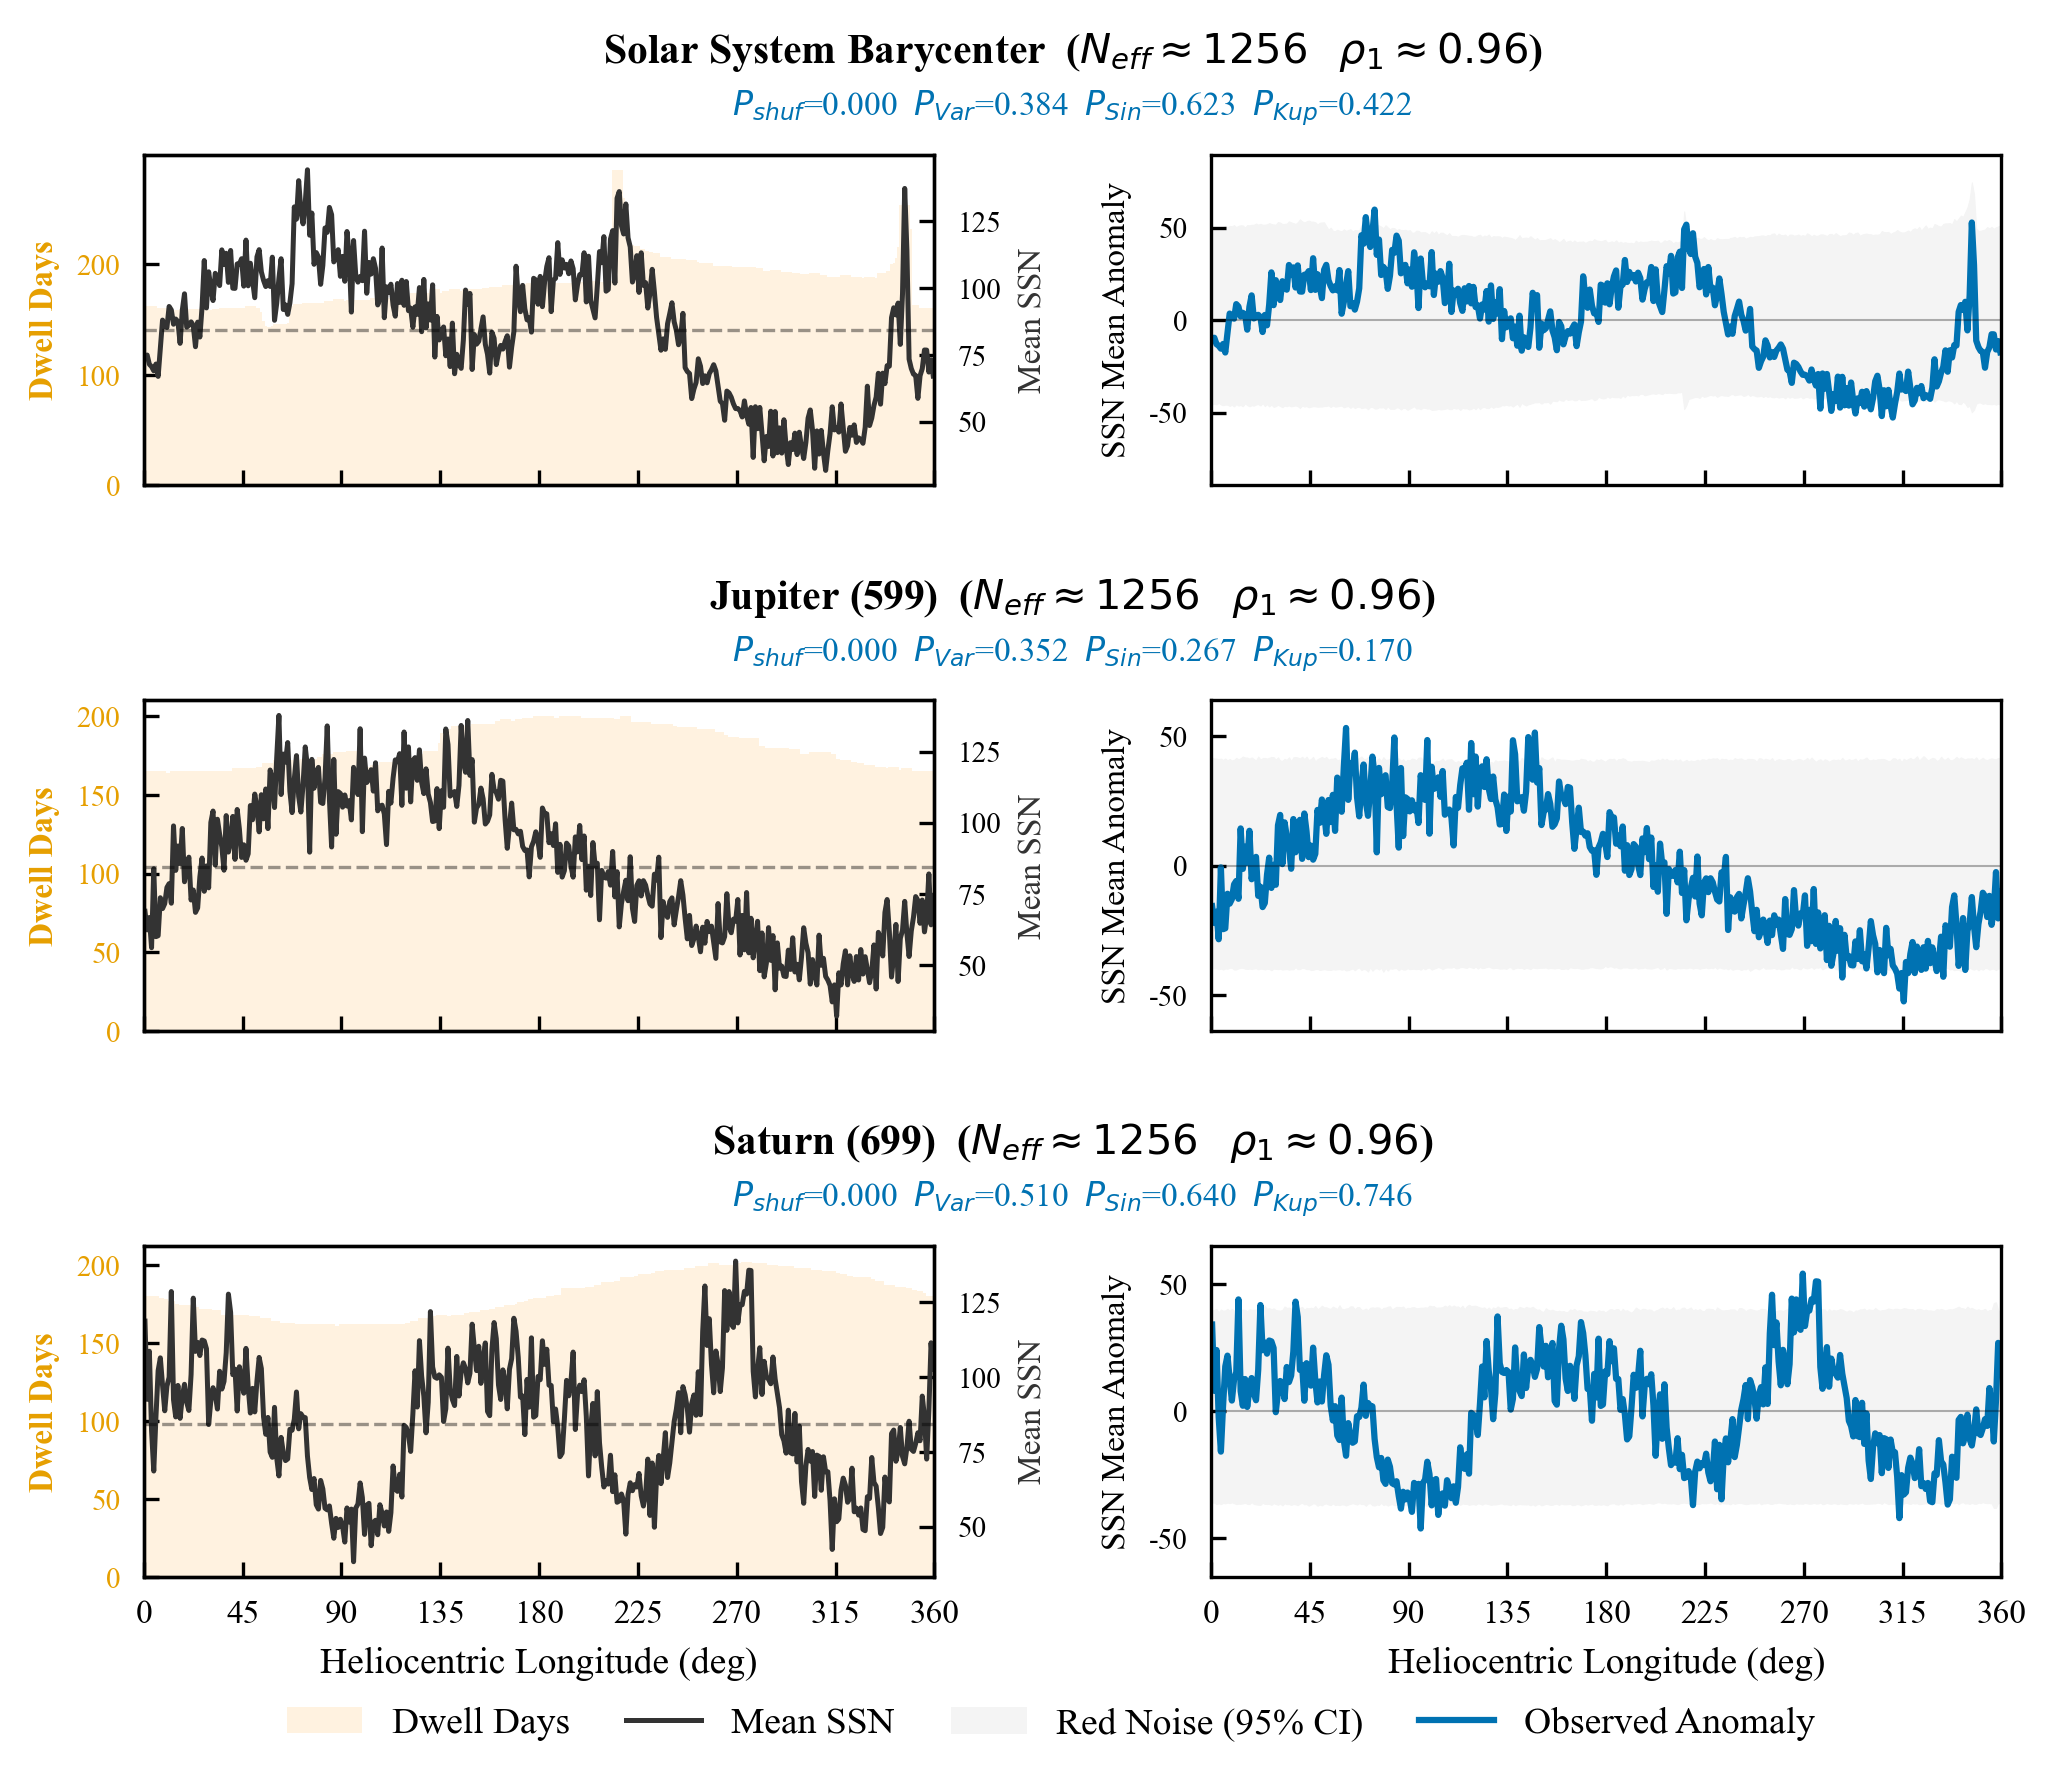

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# ----------------------------------------------------------------
# 1. Configuration and Style
# ----------------------------------------------------------------
def setup_style():
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams.update({
        'font.family': ['Times New Roman', 'serif'],
        'font.size': 10,
        'axes.unicode_minus': False,
        'xtick.direction': 'in', 'ytick.direction': 'in',
        'figure.dpi': 300, 'savefig.dpi': 300,
        'axes.labelsize': 9,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8
    })

setup_style()

# ----------------------------------------------------------------
# 2. Data Loading
# ----------------------------------------------------------------
file_ssn_path = '../../data/ready/ssn_daily_1849_2025.csv'
file_planet_path = '../../data/ready/781_planets_dwarfs_asteroids_lonlat.parquet'

print("--- Loading Data ---")
df_ssn = pd.read_csv(file_ssn_path)
df_ssn['date'] = pd.to_datetime(df_ssn['date'])
df_planet = pd.read_parquet(file_planet_path)
df_planet['date'] = pd.to_datetime(df_planet['date'])
data = pd.merge(df_ssn, df_planet, on='date', how='inner')
if 'ssn' in data.columns:
    data.rename(columns={'ssn': 'SSN'}, inplace=True)
required_cols = ['SSN', 'SSB_lon', '599_lon', '699_lon']
data = data[required_cols].dropna().copy()

# ----------------------------------------------------------------
# 3. Core Calculation Logic
# ----------------------------------------------------------------
def calculate_neff(series):
    """Calculate effective sample size"""
    rho = series.autocorr(lag=1)
    N = len(series)
    rho = min(rho, 0.999)
    neff = N * (1 - rho) / (1 + rho)
    return int(neff), rho

def get_sine_amplitude(bin_centers, bin_means):
    if len(bin_means) < 3: return 0.0
    rads = np.deg2rad(bin_centers)
    X = np.column_stack([np.ones(len(rads)), np.cos(rads), np.sin(rads)])
    try:
        beta, _, _, _ = np.linalg.lstsq(X, bin_means, rcond=None)
        return np.sqrt(beta[1]**2 + beta[2]**2)
    except:
        return 0.0

def get_kuiper_proxy(bin_anomaly):
    cum_dev = np.cumsum(bin_anomaly)
    return np.max(cum_dev) - np.min(cum_dev)

def calculate_stats_and_envelope(lon_col, ssn_col, n_permutations=10000, bin_width=1):
    neff, rho = calculate_neff(ssn_col)
    bins = np.arange(0, 361, bin_width)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    n_bins = len(bin_centers)
    global_mean = ssn_col.mean()
    
    def get_binned_means(lon, val):
        idx = np.digitize(lon, bins) - 1
        idx = np.clip(idx, 0, n_bins - 1)
        return np.bincount(idx, weights=val, minlength=n_bins) / np.maximum(np.bincount(idx, minlength=n_bins), 1)
    
    obs_means = get_binned_means(lon_col, ssn_col)
    obs_counts = np.bincount(np.digitize(lon_col, bins)-1, minlength=n_bins)[:n_bins]
    obs_anomaly = obs_means - global_mean
    
    stat_var_obs = np.var(obs_means)
    stat_sin_obs = get_sine_amplitude(bin_centers, obs_means)
    stat_kup_obs = get_kuiper_proxy(obs_anomaly)
    
    raw_ssn = ssn_col.values
    count_shuf = 0
    count_cyc_var = 0
    count_cyc_sin = 0
    count_cyc_kup = 0
    envelope_matrix = [] 
    
    for i in range(n_permutations):
        shuffled_ssn = np.random.permutation(raw_ssn)
        means_shuf = get_binned_means(lon_col, shuffled_ssn)
        if np.var(means_shuf) >= stat_var_obs: count_shuf += 1
            
        shift = np.random.randint(1, len(raw_ssn))
        cyclic_ssn = np.roll(raw_ssn, shift)
        means_cyc = get_binned_means(lon_col, cyclic_ssn)
        envelope_matrix.append(means_cyc - global_mean)
        
        if np.var(means_cyc) >= stat_var_obs: count_cyc_var += 1
        if get_sine_amplitude(bin_centers, means_cyc) >= stat_sin_obs: count_cyc_sin += 1
        anomaly_cyc = means_cyc - global_mean
        if get_kuiper_proxy(anomaly_cyc) >= stat_kup_obs: count_cyc_kup += 1
            
    envelope_matrix = np.array(envelope_matrix)
    lower_env = np.percentile(envelope_matrix, 2.5, axis=0)
    upper_env = np.percentile(envelope_matrix, 97.5, axis=0)
    
    return {
        'centers': bin_centers, 'counts': obs_counts, 'means': obs_means, 'anomaly': obs_anomaly,
        'lower_env': lower_env, 'upper_env': upper_env, 'neff': neff, 'rho': rho,
        'p_shuf': (count_shuf + 1) / (n_permutations + 1),
        'p_var': (count_cyc_var + 1) / (n_permutations + 1),
        'p_sin': (count_cyc_sin + 1) / (n_permutations + 1),
        'p_kup': (count_cyc_kup + 1) / (n_permutations + 1)
    }

# ----------------------------------------------------------------
# 4. Main Plotting Workflow & Data Saving to Excel (EPS Optimized Version)
# ----------------------------------------------------------------
targets = {
    'Solar System Barycenter': 'SSB_lon', 
    'Jupiter (599)': '599_lon', 
    'Saturn (699)': '699_lon'
}

# 1. Size Settings
fig, axes = plt.subplots(3, 2, figsize=(7.2, 6.0), sharex=True)

# 2. Spacing Adjustment
plt.subplots_adjust(left=0.08, right=0.94, top=0.92, bottom=0.13, wspace=0.35, hspace=0.65)

global_mean_ssn = data['SSN'].mean()
legend_handles = []
legend_labels = []

# Output Path
output_dir = '../../results/03_planet_artifact'
os.makedirs(output_dir, exist_ok=True)
excel_path = os.path.join(output_dir, 'Fig03_ssb_599_699_Source.xlsx')

print("--- Starting Analysis, Plotting & Saving (Excel) ---")

# [New] Define pure light colors for EPS to avoid using transparency
c_orange_text = '#E69F00'       # Dark orange: for text and axes
c_light_orange_fill = '#FFF2E0' # Very light flesh color: for bar chart fill (replaces alpha)
c_light_gray_fill = '#F4F4F4'   # Very light grey: for background fill (replaces alpha)

# Prepare list for summary data
summary_stats_list = []

# Use ExcelWriter context manager to write all sheets at once
with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    
    for i, (name, col) in enumerate(targets.items()):
        ax_left = axes[i, 0]
        ax_right = axes[i, 1]
        
        # --- A. Core Calculation ---
        res = calculate_stats_and_envelope(data[col], data['SSN'], n_permutations=10000)
        x = res['centers']
        
        # --- B. Data Saving (Write to Excel Sheet) ---
        # 1. Prepare curve data
        df_curve = pd.DataFrame({
            'Longitude_Deg': x,
            'Dwell_Days': res['counts'],
            'Mean_SSN': res['means'],
            'Observed_Anomaly': res['anomaly'],
            'RedNoise_Lower_95CI': res['lower_env'],
            'RedNoise_Upper_95CI': res['upper_env']
        })
        
        # Sheet name cannot be too long and cannot contain special characters
        sheet_name = name.replace('Solar System Barycenter', 'SSB').replace(' ', '_').replace('(', '').replace(')', '')
        # Write to corresponding sheet
        df_curve.to_excel(writer, sheet_name=sheet_name, index=False)
        
        # 2. Collect statistical summary
        summary_stats_list.append({
            'Target': name,
            'N_eff': res['neff'],
            'Rho_1': res['rho'],
            'P_Shuffle': res['p_shuf'],
            'P_Variance': res['p_var'],
            'P_Sine': res['p_sin'],
            'P_Kuiper': res['p_kup']
        })
        
        # --- C. Plotting Logic ---
        stats_line = (f"$P_{{shuf}}$={res['p_shuf']:.3f}  "
                      f"$P_{{Var}}$={res['p_var']:.3f}  "
                      f"$P_{{Sin}}$={res['p_sin']:.3f}  "
                      f"$P_{{Kup}}$={res['p_kup']:.3f}")
        info_line = f"{name}  ($N_{{eff}}\\approx{res['neff']}$   $\\rho_1\\approx{res['rho']:.2f}$)"
        
        pos_l = ax_left.get_position()
        pos_r = ax_right.get_position()
        x_center = (pos_l.x0 + pos_r.x1) / 2
        y_top = pos_l.y1 + 0.045 
        y_sub = pos_l.y1 + 0.015
        
        fig.text(x_center, y_top, info_line, ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')
        fig.text(x_center, y_sub, stats_line, ha='center', va='bottom', fontsize=8, fontweight='normal', color='#0072B2')

        # Left plot: [Modified] Use pure light color fill, remove alpha
        bar_plot = ax_left.bar(x, res['counts'], color=c_light_orange_fill, width=5.0, label='Dwell Days')
        # [Modified] Use dark color for labels to ensure contrast
        ax_left.set_ylabel('Dwell Days', color=c_orange_text, fontweight='bold', fontsize=8)
        ax_left.tick_params(axis='y', labelcolor=c_orange_text, labelsize=7)
        
        ax2_left = ax_left.twinx()
        line_ssn, = ax2_left.plot(x, res['means'], color='#333333', lw=1.2, label='Mean SSN')
        ax2_left.axhline(global_mean_ssn, color='k', linestyle='--', alpha=0.4, lw=0.8)
        ax2_left.set_ylabel('Mean SSN', color='#333333', fontsize=8)
        ax2_left.tick_params(axis='y', labelsize=7)
        ax_left.set_title("")

        # Right plot: [Modified] Use pure light color fill, remove alpha
        fill_env = ax_right.fill_between(x, res['lower_env'], res['upper_env'], 
                                         color=c_light_gray_fill, label='Red Noise (95% CI)')
        line_anom, = ax_right.plot(x, res['anomaly'], color='#0072B2', lw=1.5, label='Observed Anomaly')
        ax_right.axhline(0, color='k', linestyle='-', alpha=0.3, lw=0.5)
        ax_right.set_ylabel('SSN Mean Anomaly', fontsize=8)
        ax_right.tick_params(axis='y', labelsize=7)
        max_lim = max(abs(res['anomaly'].max()), abs(res['upper_env'].max())) * 1.2
        ax_right.set_ylim(-max_lim, max_lim)
        ax_right.set_title("")

        # Collect legend
        if i == 0:
            legend_handles = [bar_plot, line_ssn, fill_env, line_anom]
            legend_labels = ['Dwell Days', 'Mean SSN', 'Red Noise (95% CI)', 'Observed Anomaly']

        # Axes
        ax_left.set_xlim(0, 360)
        ax_right.set_xlim(0, 360)
        xticks = np.arange(0, 361, 45)
        ax_left.set_xticks(xticks)
        ax_right.set_xticks(xticks)
        if i == 2:
            ax_left.set_xlabel('Heliocentric Longitude (deg)', fontsize=9)
            ax_right.set_xlabel('Heliocentric Longitude (deg)', fontsize=9)

    # --- D. Write Summary Statistics Sheet ---
    # Place Summary in the first sheet for easy viewing
    df_summary = pd.DataFrame(summary_stats_list)
    df_summary.to_excel(writer, sheet_name='Summary_Stats', index=False)

print(f"--- All data has been integrated and saved to: {excel_path} ---")

# ----------------------------------------------------------------
# 5. Generate Global Bottom Legend & Save Image
# ----------------------------------------------------------------
fig.legend(legend_handles, legend_labels, 
           loc='lower center', 
           bbox_to_anchor=(0.5, 0.02), 
           ncol=4, 
           fontsize=9, 
           frameon=False,
           columnspacing=1.5)

save_fig_path = os.path.join(output_dir, 'Fig03_ssb_599_699.eps')

# EPS save settings (dpi=600 to guard against bitmap elements)
plt.savefig(save_fig_path, 
           format='eps',  
           dpi=600,       
           bbox_inches='tight',
           transparent=True)
print(f"--- Final chart saved: {save_fig_path} ---")


--- Loading Data ---
Data Loaded Successfully. Rows: 64495


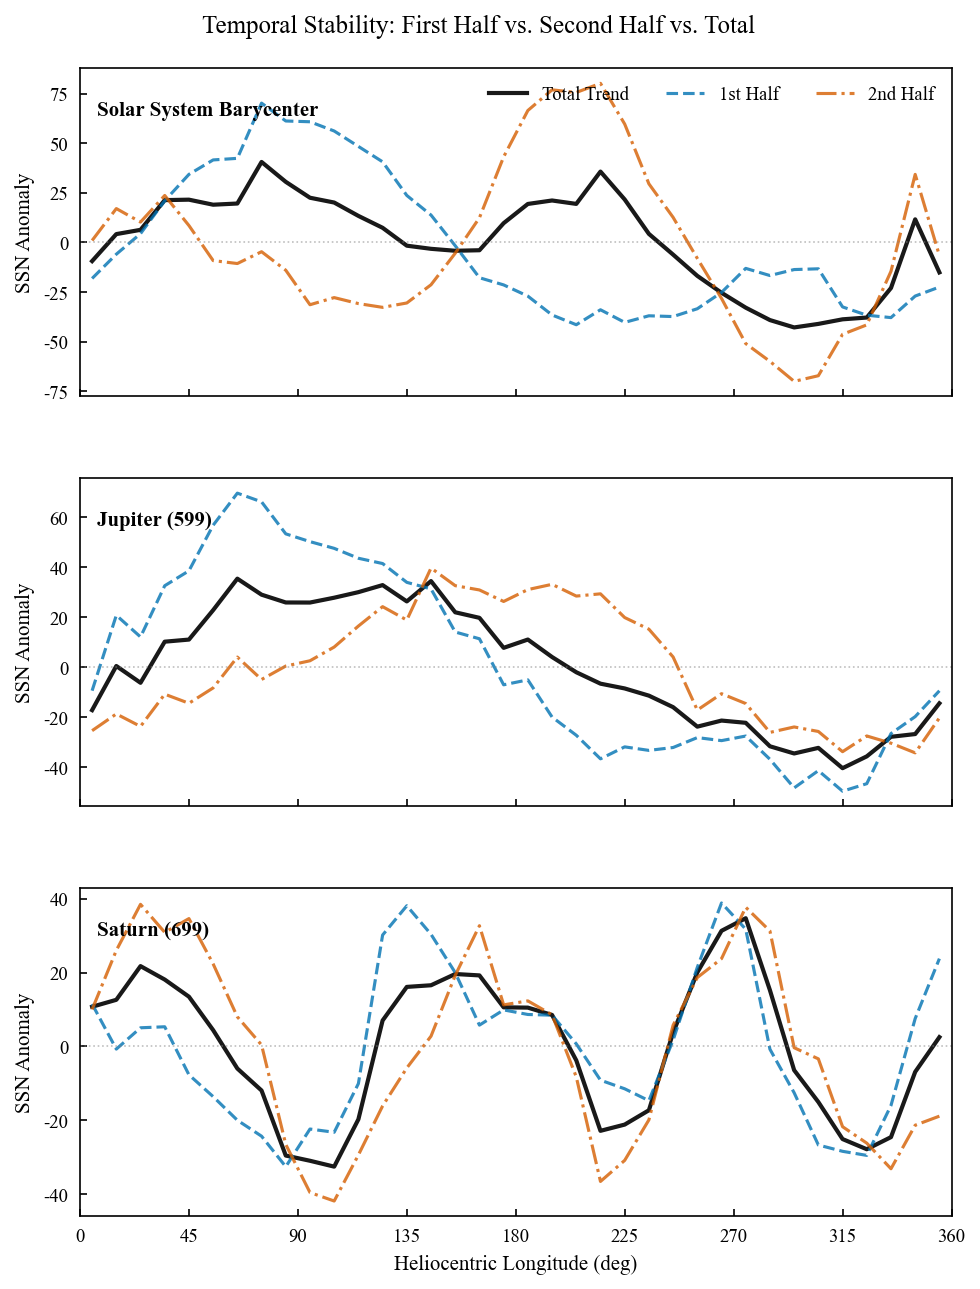

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# ----------------------------------------------------------------
# 1. Configuration and Style
# ----------------------------------------------------------------
def setup_style():
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams.update({
        'font.family': ['Times New Roman', 'serif'],
        'font.size': 10,
        'axes.unicode_minus': False,
        'xtick.direction': 'in', 'ytick.direction': 'in',
        'figure.dpi': 150, 
        'axes.labelsize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9
    })

setup_style()

# ----------------------------------------------------------------
# 2. Data Loading
# ----------------------------------------------------------------
# Adjust these paths if necessary
file_ssn_path = '../../data/ready/ssn_daily_1849_2025.csv'
file_planet_path = '../../data/ready/781_planets_dwarfs_asteroids_lonlat.parquet'

print("--- Loading Data ---")
try:
    df_ssn = pd.read_csv(file_ssn_path)
    df_ssn['date'] = pd.to_datetime(df_ssn['date'])
    
    df_planet = pd.read_parquet(file_planet_path)
    df_planet['date'] = pd.to_datetime(df_planet['date'])
    
    # Merge
    data = pd.merge(df_ssn, df_planet, on='date', how='inner')
    
    if 'ssn' in data.columns:
        data.rename(columns={'ssn': 'SSN'}, inplace=True)
        
    required_cols = ['SSN', 'SSB_lon', '599_lon', '699_lon']
    data = data[required_cols].dropna().copy()
    print(f"Data Loaded Successfully. Rows: {len(data)}")

except Exception as e:
    print(f"Error loading data: {e}")
    # Create dummy data for demonstration if files are missing
    print("Creating dummy data for demonstration...")
    dates = pd.date_range(start='1849-01-01', end='2025-01-01', freq='D')
    data = pd.DataFrame({
        'date': dates,
        'SSN': np.abs(np.sin(np.linspace(0, 100, len(dates))) * 100 + np.random.normal(0, 20, len(dates))),
        'SSB_lon': np.linspace(0, 360*10, len(dates)) % 360,
        '599_lon': np.linspace(0, 360*15, len(dates)) % 360,
        '699_lon': np.linspace(0, 360*6, len(dates)) % 360
    })

# ----------------------------------------------------------------
# 3. Calculation & Plotting Logic
# ----------------------------------------------------------------
def calculate_binned_anomaly(df, lon_col, val_col, bin_width=10):
    """
    Calculates the mean anomaly of a value column based on longitude bins.
    Anomaly = Bin Mean - Global Mean of that dataset segment.
    """
    # Create bins (0 to 360)
    bins = np.arange(0, 361, bin_width)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Digitize data into bins (indices 1 to N, subtract 1 for 0-based)
    inds = np.digitize(df[lon_col], bins) - 1
    inds = np.clip(inds, 0, len(bin_centers) - 1)
    
    # Calculate means efficiently
    count = np.bincount(inds, minlength=len(bin_centers))
    total = np.bincount(inds, weights=df[val_col], minlength=len(bin_centers))
    
    # Avoid division by zero
    means = np.divide(total, count, out=np.zeros_like(total), where=count!=0)
    
    # Calculate anomaly relative to the specific subset's global mean
    global_mean = df[val_col].mean()
    anomaly = means - global_mean
    
    return bin_centers, anomaly

def plot_three_body_comparison(data):
    # Targets configuration
    targets = {
        'Solar System Barycenter': 'SSB_lon', 
        'Jupiter (599)': '599_lon', 
        'Saturn (699)': '699_lon'
    }
    
    # Split data based on median date
    # Re-verify 'date' column exists for splitting, if not use index
    if 'date' in data.columns:
        mid_date = data['date'].median()
        mid_label = str(mid_date.year)
        df_early = data[data['date'] <= mid_date].copy()
        df_late = data[data['date'] > mid_date].copy()
    else:
        # Fallback if date column was lost in cleaning
        mid_idx = len(data) // 2
        mid_label = "Mid-Point"
        df_early = data.iloc[:mid_idx].copy()
        df_late = data.iloc[mid_idx:].copy()

    # Setup Plot (3 Rows, 1 Column)
    fig, axes = plt.subplots(3, 1, figsize=(7, 9), sharex=True)
    plt.subplots_adjust(top=0.93, bottom=0.08, left=0.12, right=0.95, hspace=0.25)
    
    axes_list = axes.flatten()
    
    # Loop through targets
    for i, (name, col) in enumerate(targets.items()):
        ax = axes_list[i]
        
        # Calculate curves (Bin width = 10 deg for smoother trends)
        x, y_total = calculate_binned_anomaly(data, col, 'SSN', bin_width=10)
        _, y_early = calculate_binned_anomaly(df_early, col, 'SSN', bin_width=10)
        _, y_late  = calculate_binned_anomaly(df_late, col, 'SSN', bin_width=10)
        
        # Plot Lines
        # 1. Total Trend (Black, Bold)
        ax.plot(x, y_total, color='black', lw=2.0, alpha=0.9, 
                label='Total Trend' if i == 0 else "")
        
        # 2. First Half (Blue, Dashed)
        ax.plot(x, y_early, color='#0072B2', lw=1.5, ls='--', alpha=0.8, 
                label=f'1st Half' if i == 0 else "")
        
        # 3. Second Half (Red, Dash-dot)
        ax.plot(x, y_late, color='#D55E00', lw=1.5, ls='-.', alpha=0.8, 
                label=f'2nd Half' if i == 0 else "")
        
        # Styling
        ax.axhline(0, color='gray', lw=0.8, ls=':', alpha=0.5)
        ax.set_ylabel('SSN Anomaly', fontsize=10)
        # Place title inside or just above
        ax.text(0.02, 0.9, name, transform=ax.transAxes, fontsize=10, fontweight='bold', va='top')
        
        # Legend only on top plot
        if i == 0:
            ax.legend(loc='upper right', frameon=False, fontsize=9, ncol=3)
            
    # X-axis label
    axes_list[-1].set_xlabel('Heliocentric Longitude (deg)', fontsize=10)
    axes_list[-1].set_xlim(0, 360)
    axes_list[-1].set_xticks(np.arange(0, 361, 45))
    
    fig.suptitle('Temporal Stability: First Half vs. Second Half vs. Total', fontsize=12, y=0.97)
    plt.show()

# ----------------------------------------------------------------
# 4. Execution
# ----------------------------------------------------------------
plot_three_body_comparison(data)